In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.corpora import Dictionary
import joblib
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

SOME_FREE_SONGTEXT = "So one night I said to Kathy We gotta get away somehow Go somewhere south and somewhere warm But for God's sake let's go now. And Kathy she sort of looks at me And asks where I wanna go So I look back and I hear me say I don't care but we gotta go chorus and key change And all the other people Who slepwalk thru their days Just sort of faded out of sight When we two drove away And ev'ry day we travelled We were lookin' to get wise And we learned what was the truth And we learned what were the lies And in LA we bought a bus Sort of old and not too smart So for six hundred and fifty bucks We got out and made a start We hit the road down to the South And drove into Mexico That old bus was some old wreck But it just kept us on the road. chorus etc We drove up to Alabam And a farmer gave us some jobs We worked them crops all night and day And at night we slept like dogs We got paid and Kathy said to me It's time to make a move again And when I looked into her eyes I saw more than a friend. chorus etc And now we've stopped our travels And we sold the bus in Texas And we made our home in Austin And for sure it ain't no palace And Kathy and me we settled down And now our first kid's on the way Kathy and me and that old bus We did real good to get away."

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-17 18:27:46.891792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 18:27:46.956200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 18:27:46.956249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 18:27:46.956319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

In [2]:
def load_songs(filename, nrows=None):
        return pd.read_csv(filename, sep='\t', nrows=nrows)


def load_artists(filename, nrows=None):
        return pd.read_csv(filename, sep=',', nrows=nrows)

def load_albums(filename, nrows=None):
        return pd.read_csv(filename, sep='\t', nrows=nrows)

def random_key_from_dict(dictionary, seed=123):
        keys_list = list(dictionary.keys())
        np.random.seed(seed)
        random_index = np.random.choice(len(keys_list))
        return keys_list[random_index]

In [3]:
### Quick overview over some columns
df = load_songs('wasabi_songs.csv', nrows=10000)
for property in ['artist', 'title', 'publicationDateAlbum', 'album_genre',
                 'valence', 'arousal', 'valence_predicted', 'arousal_predicted', 'bpm']:
    print('Histogram for:', property)
    print(pd.value_counts(df[property]), '\n\n')
    

# remove rows that either have NaN in relevant feature or bpm cell(s)
clean_df = df[['artist', 'title', 'publicationDateAlbum', 'album_genre','bpm']].dropna()
clean_df.info()



Histogram for: artist
artist
ABBA                   367
Aaron Neville          303
A-ha                   174
Aaron Tippin           156
Aaliyah                122
                      ... 
A Girl Called Jane       1
A Reminiscent Drive      1
A Genuine Freakshow      1
A Friend In London       1
Aalon                    1
Name: count, Length: 559, dtype: int64 


Histogram for: title
title
Intro                                                  15
Dancing Queen                                           9
Knowing Me, Knowing You                                 8
Untitled                                                8
Gimme! Gimme! Gimme! (A Man After Midnight)             8
                                                       ..
A Life Once Cherished                                   1
Knights And Thieves (In The Search Of The Covenant)     1
To The Heartless                                        1
In The Eyes Of A Traitor                                1
Debajo De La Morera      

/tmp/ipykernel_6131/345721662.py:2: DtypeWarning: Columns (41,42,43,50,67) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, sep='\t', nrows=nrows)
/tmp/ipykernel_6131/3970512764.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/3970512764.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/3970512764.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/3970512764.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

/tmp/ipykernel_6131/345721662.py:2: DtypeWarning: Columns (41,42,43,50,67,74) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, sep='\t', nrows=nrows)


Histogram for: artist
artist
Andy Williams           669
André Van Duin          616
Adriano Celentano       515
Aerosmith               496
André Hazes             478
                       ... 
All The Hits Now          1
All The Ashes             1
All Star Weekend          1
Adam Trent                1
Alec R. Constandinos      1
Name: count, Length: 4287, dtype: int64 


Histogram for: title
title
Intro                            138
Untitled                          36
Angel                             33
Beautiful                         29
Goodbye                           27
                                ... 
Metris'in Önünde                   1
Bacalar / Kara Toprak (Mamoş)      1
Kod Adı Bahtiyar                   1
İyimser Bir Gül                    1
The Nanny Named Fran               1
Name: count, Length: 79648, dtype: int64 


Histogram for: publicationDateAlbum
publicationDateAlbum
2006.0    4319
2007.0    3676
2005.0    3624
2004.0    3583
2003.0    3321
          

/tmp/ipykernel_6131/1314339049.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/1314339049.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/1314339049.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/1314339049.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[property]), '\n\n')
/tmp/ipykernel_6131/1314339049.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use p

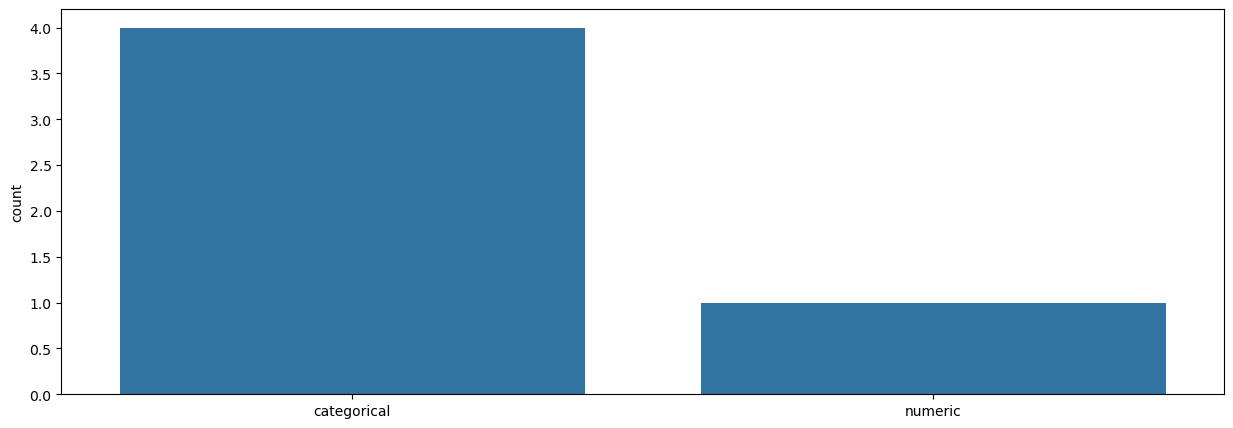

In [4]:
### Quick overview over some columns
df = load_songs('wasabi_songs.csv', nrows=100000)
for property in ['artist', 'title', 'publicationDateAlbum', 'album_genre',
                 'valence', 'arousal', 'valence_predicted', 'arousal_predicted', 'bpm']:
    print('Histogram for:', property)
    print(pd.value_counts(df[property]), '\n\n')
    

# remove rows that either have NaN in relevant feature or bpm cell(s)
clean_df = df[['artist', 'title', 'publicationDateAlbum', 'album_genre','bpm']].dropna()
clean_df.info()

column_data_type = []
for col in clean_df.columns:
    data_type = clean_df[col].dtype
    if clean_df[col].dtype in ['int64','float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
plt.figure(figsize=(15,5))
sns.countplot(x=column_data_type)
plt.show()

Next Step: Make new df with all relevant features we want to incorporate

In [5]:

features = pd.get_dummies(clean_df[['artist', 'title', 'publicationDateAlbum', 'album_genre', 'bpm']])

X = features
y = features["bpm"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)



X_train.describe().transpose()[['mean', 'std']]


,mean,std
bpm,129.734639,27.705985


In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print('adapted')
first = np.array(X_train[:1])
print('first array')
normalizer.mean.numpy()

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


: 